## EPL Shot Simulation

For today's viz we'll simulate the probabilities that a player scored an $x$ amount of goals based on their xG figures.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
import matplotlib.font_manager as fm
from highlight_text import fig_text, ax_text

from mplsoccer import Pitch

from PIL import Image
import urllib
import os

In [2]:
font_path = "../assets/fonts"
for x in os.listdir(font_path):
    for y in os.listdir(f"{font_path}/{x}"):
        if y.split(".")[-1] == "otf":
            fm.fontManager.addfont(f"{font_path}/{x}/{y}")
            try:
                fm.FontProperties(weight=y.split("-")[-1].split(".")[0].lower(), fname=y.split("-")[0])
            except Exception:
                continue

plt.style.use("../assets/stylesheets/soc_base.mplstyle")
plt.rcParams['font.family'] = 'Comico'

## Loading the data

In [3]:
df = pd.read_csv('data/10312022_epl_shots.csv', index_col=0)
df.head()

,shot_id,event_type,team_id,player_id,player_name,shot_x,shot_y,min,min_added,is_blocked,...,goal_crossed_z,xG,xGOT,shot_type,situation,period,is_own_goal,on_goal_x,on_goal_y,short_name
0,2443406693,AttemptSaved,8654,523825,Jarrod Bowen,95.929825,33.008751,2,NaN,True,...,1.220000,0.173840,NaN,LeftFoot,FromCorner,FirstHalf,False,55.892857,14.239029,NaN
1,2443411697,AttemptSaved,8654,158545,Michail Antonio,96.991227,38.704525,2,NaN,True,...,1.245684,0.082090,NaN,LeftFoot,RegularPlay,FirstHalf,False,7.782738,14.538798,NaN
2,2443406789,Miss,8654,158545,Michail Antonio,97.087716,34.686251,3,NaN,False,...,3.376828,0.090813,NaN,Header,FromCorner,FirstHalf,False,102.929726,39.412087,NaN
3,2443411153,AttemptSaved,8456,169200,Kevin De Bruyne,81.471358,22.668026,9,NaN,True,...,1.220000,0.019727,NaN,LeftFoot,RegularPlay,FirstHalf,False,62.247024,14.239029,NaN
4,2443414481,Miss,8456,169200,Kevin De Bruyne,90.699997,25.129062,14,NaN,False,...,0.269684,0.138967,NaN,RightFoot,RegularPlay,FirstHalf,False,0.000000,3.147575,NaN


Now that we have the data loaded, we compute the top 6 scorers in the league.

In [209]:
top_scorers = (
    df[(df['is_own_goal'] == False) & (df['event_type'] == 'Goal')]
    .groupby(['player_id', 'player_name', 'event_type', 'team_id'])
    .agg({'shot_id':'count'})
    .reset_index()
    .rename(columns={'shot_id':'goals'})
)
top_scorers = top_scorers.sort_values(by='goals', ascending=False).head(6).reset_index(drop=True)
top_scorers

,player_id,player_name,event_type,team_id,goals
0,737066,Erling Braut Haaland,Goal,8456,17
1,194165,Harry Kane,Goal,8586,10
2,351860,Aleksandar Mitrovic,Goal,9879,9
3,408987,Ivan Toney,Goal,9937,8
4,318615,Leandro Trossard,Goal,10204,7
5,442277,Miguel Almiron,Goal,10261,7


Great!

Now let's filter the data to only these players.

In [73]:
df = df[df['player_id'].isin(top_scorers['player_id'])]

## Simulating the number of goals

In [74]:
def sim_goal_on_xG(xG):
    goal = np.random.choice([0,1], p=[1-xG, xG])
    return goal

def sim_player_goals(player_id, simulations=1000, data=df):
    df = data.copy()
    player_df = df[df['player_id'] == player_id]
    simulation_track = {
        'goals': [],
        'simulation_id': []
    }
    for sim in range(0, simulations):
        total_goals = 0
        for x in player_df['xG']:
            goal = sim_goal_on_xG(x)
            total_goals += goal
        simulation_track['goals'].append(total_goals)
        simulation_track['simulation_id'].append(sim)
    simulation_track = pd.DataFrame(simulation_track)
    return simulation_track

Let's test it for Ivan Toney.

In [7]:
toney = sim_player_goals(408987, simulations=5000)

In [75]:
toney = toney.groupby(['goals']).count().reset_index()
toney['prob'] = toney['simulation_id']/5000

Now we do it for every player.

In [76]:
df_simulated = pd.DataFrame()
for player in top_scorers['player_id']:
    df_aux = sim_player_goals(player, simulations=5000)
    df_aux = df_aux.groupby(['goals']).count().reset_index()
    df_aux['prob'] = df_aux['simulation_id']/5000
    df_aux['player_id'] = player
    df_simulated = pd.concat([df_simulated, df_aux])
df_simulated = df_simulated.reset_index(drop=True)

## The Basic Visual

In [77]:
plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.edgecolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plt.rcParams['hatch.linewidth'] = .35
plt.rcParams['hatch.color'] = '#E34602'

In [206]:
def plot_goal_sim(ax, player_id, label_x=False, label_y=False):
    ax.set_xlim(df_simulated['goals'].min(), df_simulated['goals'].max())
    ax.set_ylim(0, .3)

    true_goals = top_scorers[top_scorers['player_id'] == player_id].goals.iloc[0]
    player_sim = df_simulated[df_simulated['player_id'] == player_id]

    bars_ = ax.bar(player_sim['goals'], player_sim['prob'], fc='#FE9A0A', hatch='ooooo')
    # -- We need to compute the location of the bar of the actual goals
    min_goals = player_sim['goals'].min()
    true_goal_pos = true_goals - min_goals
    bars_[true_goal_pos].set_color('#13B042')
    bars_[true_goal_pos].set_hatch('ooooo')
    bars_[true_goal_pos].set_edgecolor('#0FFC56')
    true_goal_prob = bars_[true_goal_pos].get_height()

    ax.annotate(
        xy=(true_goals, true_goal_prob),
        text=f'{true_goal_prob:.1%}',
        xytext=(2,10),
        textcoords='offset points',
        ha='center',
        va='center',
        color='#0FFC56',
        size=7
    )

    ax.yaxis.set_major_locator(ticker.MultipleLocator(.05))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0%}'))
    if label_x:
        ax.set_xlabel('Goals', color='white')
    if label_y:
        ax.set_ylabel('Probability', color='white')

    # -- Let's get fancy
    ax.annotate(
        text='', xy=(0.5, .28), 
        xytext=(true_goals - .5, .28), 
        arrowprops=dict(arrowstyle='<->', color='#FFFFFF'), color='white')
    under_prob = player_sim[player_sim['goals'] < true_goals]['prob'].sum()
    ax_text(
        s=f'{under_prob:.1%} of underperf.\n<actual goals>', x=(0.5 + true_goals - .5)/2, y=.285, 
        ha='center', va='bottom', color='white', size=5, highlight_textprops=[{'color':'#0FFC56'}], ax=ax)
    if (ax.get_xlim()[1] - 0.5 - true_goals + 1) > 3:
        ax.annotate(
            text='', xy=(ax.get_xlim()[1] - 0.5, .28), 
            xytext=(true_goals + 1, .28), 
            arrowprops=dict(arrowstyle='<->', color='#FFFFFF'), color='white')
        over_prob = player_sim[player_sim['goals'] > true_goals]['prob'].sum()
        ax_text(
            s=f'{over_prob:.1%} of outperf.\n<actual goals>', x=true_goals + 1 + (ax.get_xlim()[1] - true_goals - 1)/2, y=.285, 
            ha='center', va='bottom', color='white', size=5, highlight_textprops=[{'color':'#0FFC56'}], ax=ax)

    # -- Player title
    player_name = top_scorers[top_scorers['player_id'] == player_id]['player_name'].iloc[0]
    xG_player = df[df['player_id'] == player_id]['xG'].sum()
    xGOT_player = df[df['player_id'] == player_id]['xGOT'].sum()
    ax_text(
        x=0, y=ax.get_ylim()[1]*1.1,
        s=f"<{player_name}> | Goals {true_goals:.0f} | xG {xG_player:.1f} | xGOT {xGOT_player:.1f}",
        size=6,
        color='white',
        ha='left',
        va='center',
        highlight_textprops=[{'size':12}],
        ax=ax
    )

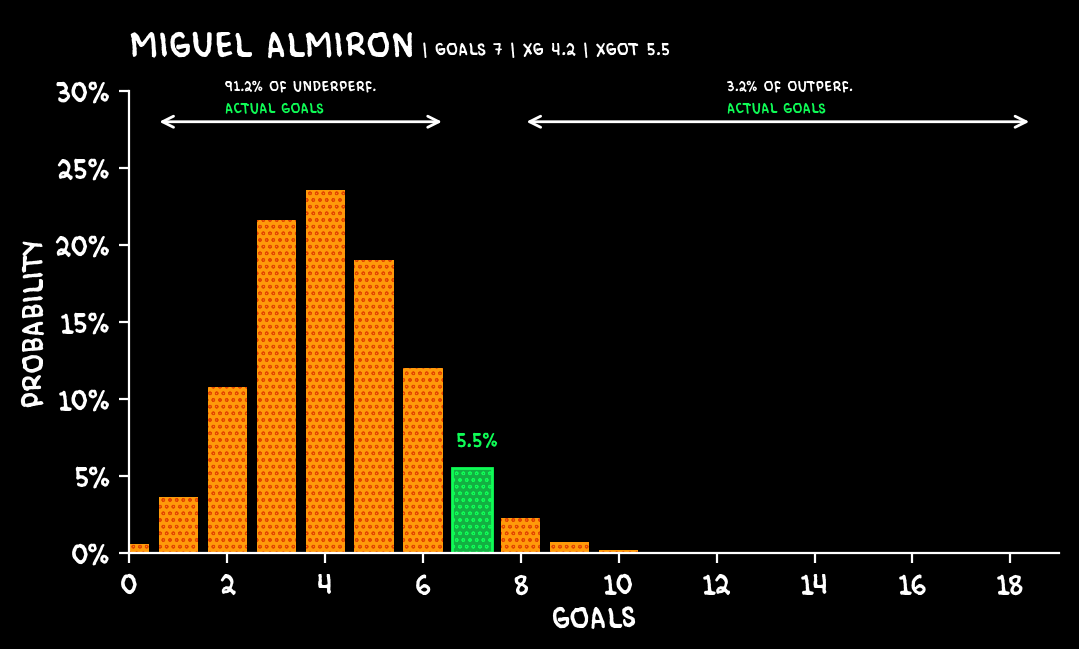

In [207]:
fig = plt.figure(figsize=(6,3), dpi=200, facecolor='#000000')
ax = plt.subplot(facecolor='#000000')

plot_goal_sim(ax, player_id=442277, label_x=True, label_y=True)

## The Final Viz

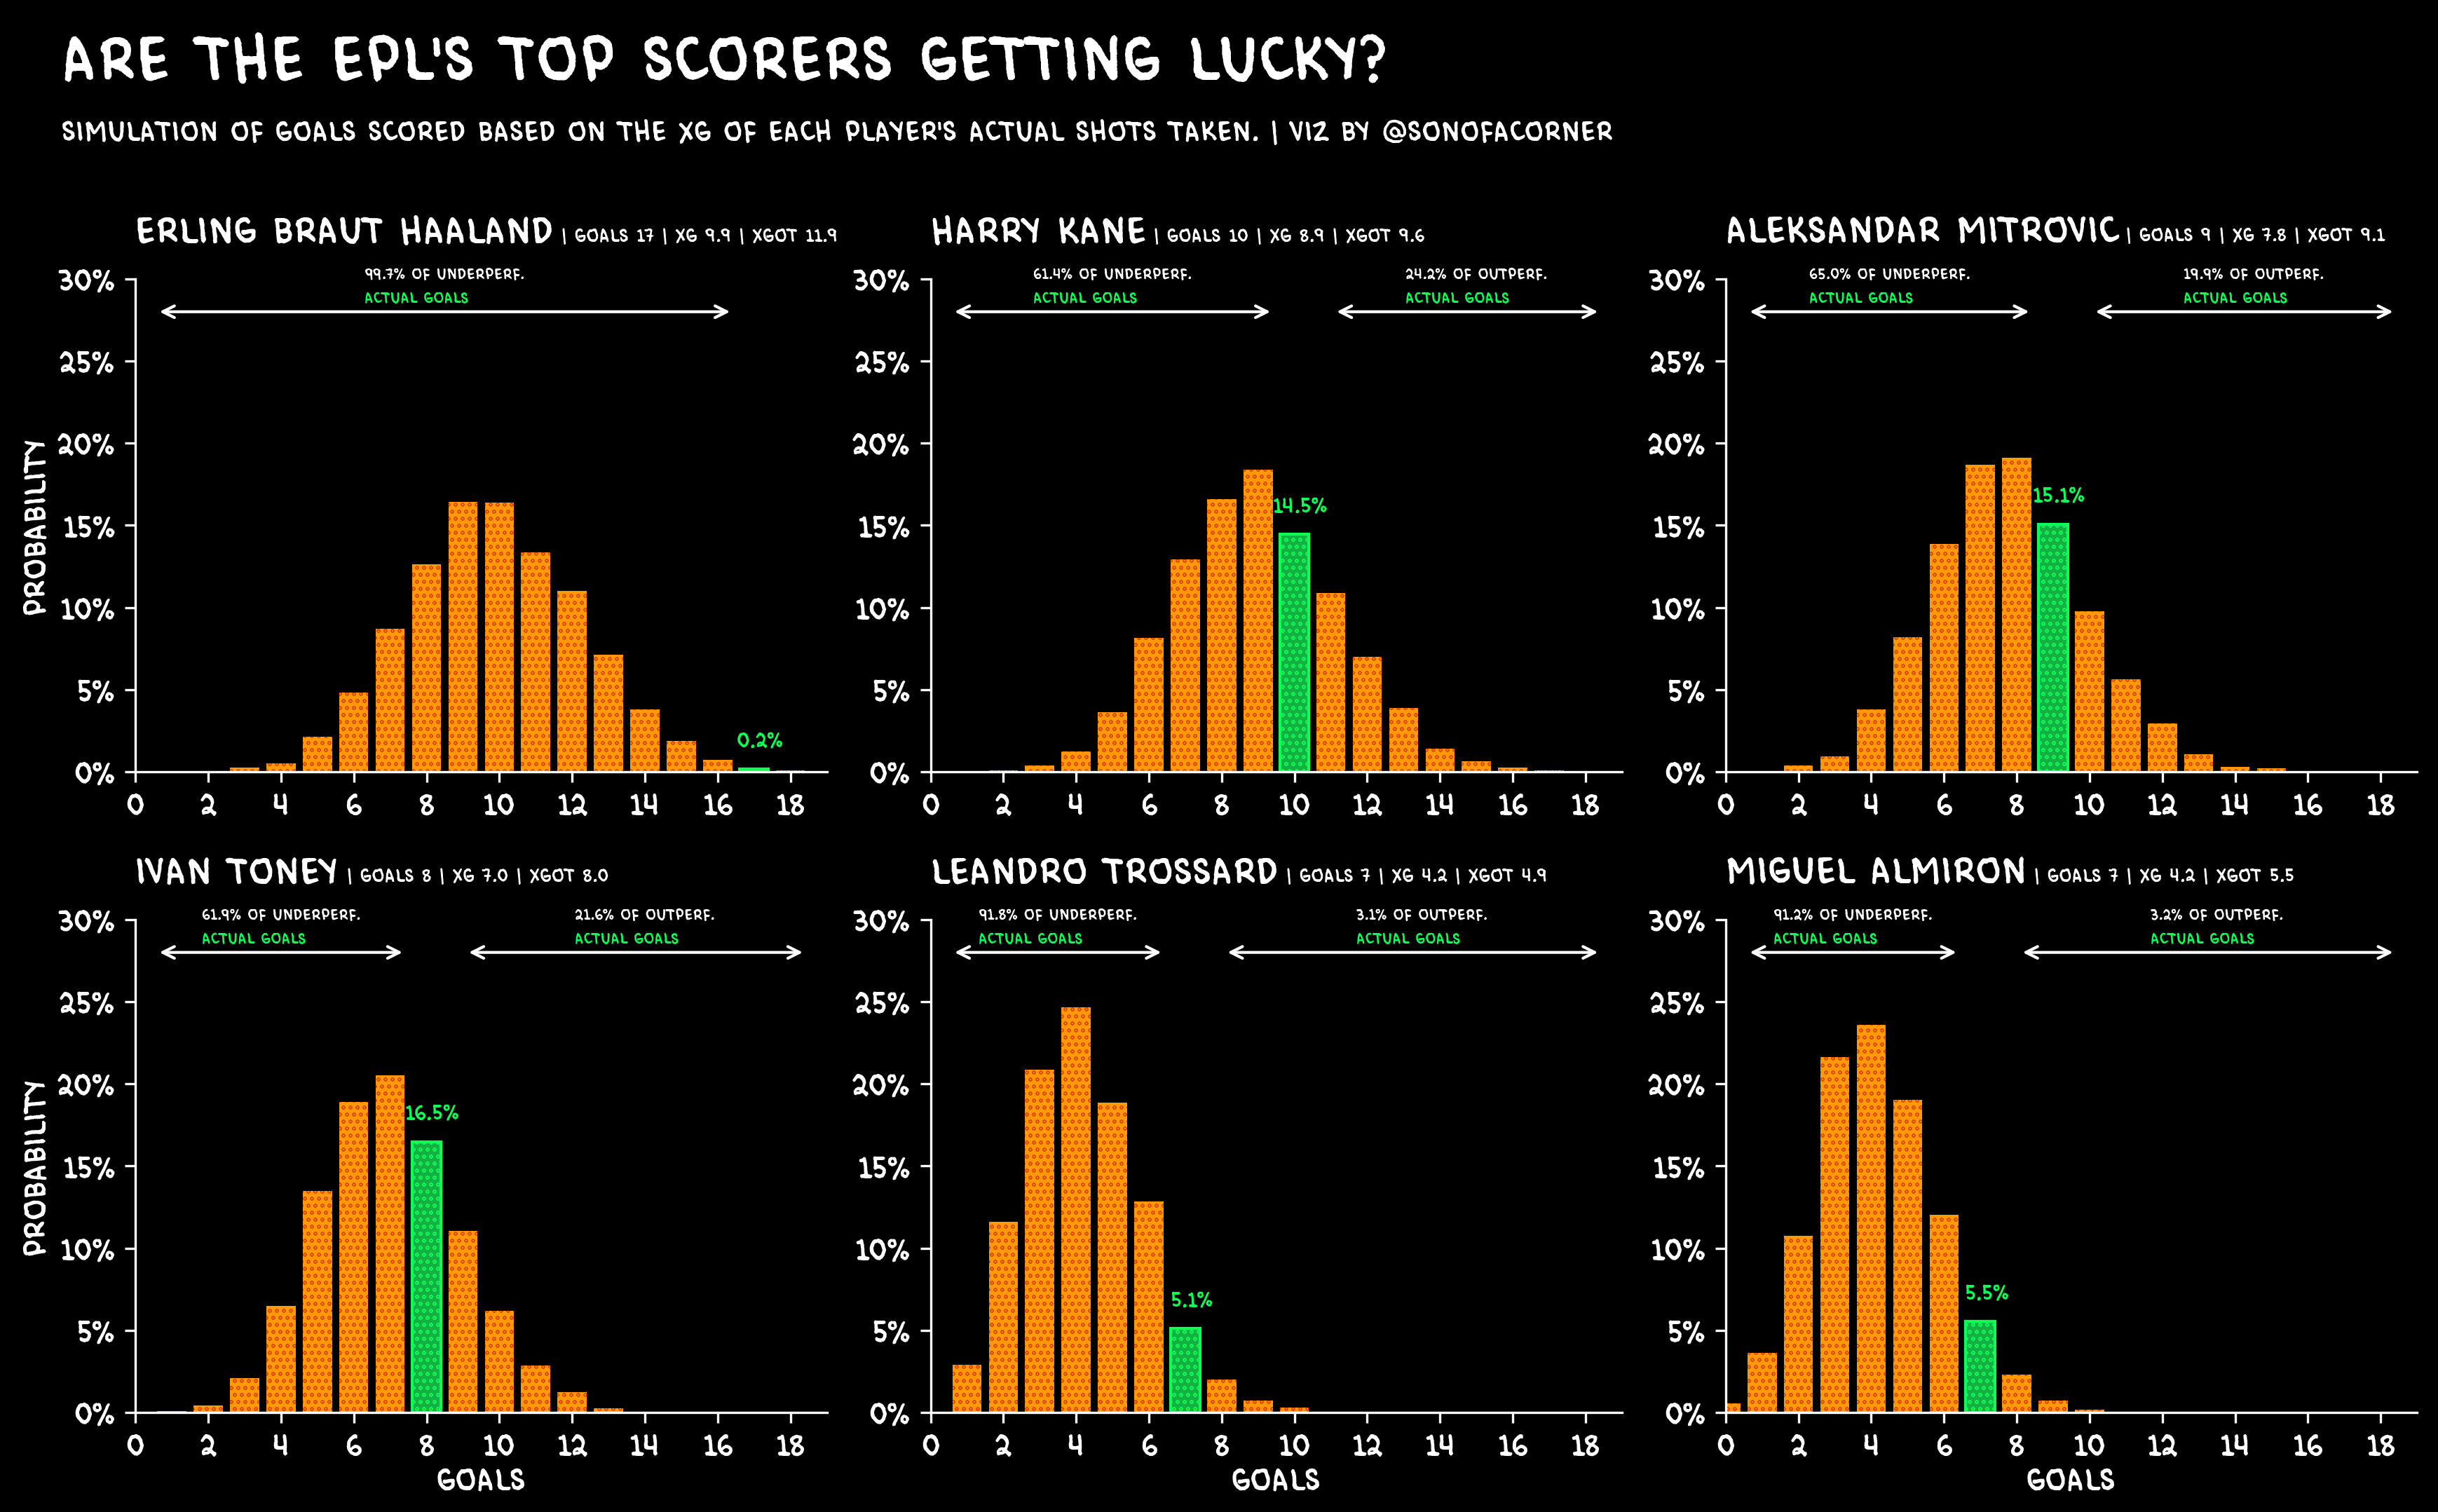

In [222]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(14,7), dpi=300, facecolor='#000000')
axs = np.array(axs)
for index, ax in enumerate(axs.reshape(-1)):
    ax.set_facecolor('#000000')
    if index < 3:
        label_x = False
    else:
        label_x = True
    if index in [0,3]:
        label_y = True
    else:
        label_y = False
    plot_goal_sim(ax, player_id=top_scorers['player_id'].iloc[index], label_x=label_x, label_y=label_y)

plt.subplots_adjust(wspace=0.15, hspace=.3)
# We add the logos once we've reshaped the figure
fig_text(
    x=0.1,y=1.03,
    s='Are the EPL\'s Top Scorers Getting Lucky?',
    ha='left',
    va='center',
    size='20',
    color='white'  
)
fig_text(
    x=0.1,y=.98,
    s='Simulation of goals scored based on the xG of each player\'s actual shots taken. | Viz by @sonofacorner',
    ha='left',
    va='center',
    size='9',
    color='white'  
)

plt.savefig(
	"figures/10312022_epl_goals.png",
	dpi = 600,
	bbox_inches="tight",
    edgecolor="none",
	transparent = False
)